In [16]:
pip install python-louvain

In [17]:
pip install community

  Using cached community-1.0.0b1-py3-none-any.whl
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [18]:
import networkx as nx
import community as community_louvain
import numpy as np
import locale
import time

In [19]:
pip install community

  Using cached community-1.0.0b1-py3-none-any.whl
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


### Création du graphe à partir du fichier `edgelist`

In [20]:
G = nx.read_edgelist("/youtube.graph.edgelist", nodetype=int)

In [21]:
N = G.number_of_nodes()
m = G.number_of_edges()
nb_composantes = nx.number_connected_components(G)

In [22]:
print(f"nombre de nœuds : {N}")
print(f"nombre d’arêtes : {m}")
print(f"nombre de composantes connexes : {nb_composantes}")
print(f"voisins du nœud 1 : {list(G.neighbors(11))}")

nombre de nœuds : 22754
nombre d’arêtes : 65601
nombre de composantes connexes : 1
voisins du nœud 1 : [165, 349, 718, 727, 743, 905, 908, 1042, 1073, 1119, 3491, 3493, 3511, 3517, 3518, 3519, 3533, 3535, 3540, 3542, 3546, 3548, 3558, 3559, 3562, 5109, 13568, 655575, 663545, 665658, 665659, 1085697]


### Budget idéal et couverture idéale

In [23]:
def ideal_budget_and_coverage(N, C_0=200):
    return C_0*N, 1

In [24]:
C_0 = 200
ideal_budget, ideal_coverage = ideal_budget_and_coverage(N, C_0)
print(f"budget idéal = {ideal_budget:,.2f} CAD et couverture idéale = {ideal_coverage:.0%}")

budget idéal = 4,550,800.00 CAD et couverture idéale = 100%


### Détection des communautés à l’aide de l’algorithme de Louvain.

In [25]:
def get_communities(G, algo="louvain"):
    communities = {}
    if algo=="louvain":
        partition = community_louvain.best_partition(G)
        for node, comm in partition.items():
            communities.setdefault(comm, []).append(node)
    else:
        lpa_communities = nx.algorithms.community.label_propagation_communities(G)
        lpa_result = [list(c) for c in lpa_communities]
        for i, comm in enumerate(lpa_communities):
            communities[i] = list(comm)
    return communities

In [26]:
communities_lpa = get_communities(G, algo="lpa")
print("nombre total de communautés détectées :", len(communities_lpa))

nombre total de communautés détectées : 1319


In [27]:
import community.community_louvain as community_louvain

communities_louvain = get_communities(G, algo="louvain")
print("nombre total de communautés détectées :", len(communities_louvain))

nombre total de communautés détectées : 37


### Détermination d’un·e influenceur·euse par communauté, choisi·e selon la centralité de proximité

In [28]:
def get_community_and_profiles(G, communities, influence="closeness"):
    com_and_profiles = {}
    for comm_id, nodes in communities.items():
        community = G.subgraph(nodes)
        if influence=="closeness":
            closeness = nx.closeness_centrality(community)
            influencer = max(closeness, key=closeness.get)
        elif influence=="degree":
            degree = nx.degree_centrality(community)
            influencer = max(degree, key=degree.get)
        elif influence=="betweenness":
            betweenness = nx.betweenness_centrality(community)
            influencer = max(betweenness, key=betweenness.get)
        else:
            influencer = np.random.choice(list(nodes))
        profile = {"community":community, "influencer": influencer}
        com_and_profiles[comm_id]=profile
    return com_and_profiles

In [29]:
com_and_profiles_louvain = get_community_and_profiles(G, communities_louvain, influence="closeness")

In [30]:
com_and_profiles_lpa = get_community_and_profiles(G, communities_lpa, influence="random")

###  Simulation du budget et de la couverture obtenue par propagation de l’influence

In [31]:
def get_budget_coverage_per_community(com_and_profile, N, eta = 2, C_1=20, C_2=1000):
    community = com_and_profile['community']
    influencer = com_and_profile['influencer']
    counter = 1
    temps_propagation = 0
    for node in community.nodes():
        if node != influencer:
            prob = np.random.uniform(0.8, 1)
            choice = np.random.choice([0, 1], p=[1-prob, prob])
            if choice == 1:
                try:
                    distance = nx.shortest_path_length(community, source=influencer, target=node)
                    counter +=1
                    temps_propagation += distance
                except Exception as e:
                    continue

    budget = C_2 + (counter-1)*C_1
    temps_propagation *= eta
    coverage = counter/N
    return budget, coverage, temps_propagation

In [32]:
def get_budget_and_coverage(com_and_profiles, eta=2, C_1=20, C_2=1000):
    total_budget, total_coverage, total_temps_propagation = 0, 0, 0
    for comm_id in com_and_profiles:
        com_and_profile = com_and_profiles[comm_id]
        budget, coverage, temps_propagation = get_budget_coverage_per_community(com_and_profile, N, eta, C_1, C_2)
        total_budget +=budget
        total_coverage +=coverage
        total_temps_propagation +=temps_propagation
    return total_budget, total_coverage, total_temps_propagation

In [33]:
eta, C_1, C_2 =2, 20, 1000

In [34]:
sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles_louvain, eta, C_1, C_2)
print(f"budget simulé = {sim_budget:,.2f} CAD, couverture simulée = {sim_coverage:.0%} et temps de propagation = {sim_temps_propagation:,.2f} sec ")

budget simulé = 446,520.00 CAD, couverture simulée = 90% et temps de propagation = 92,880.00 sec 


In [35]:
sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles_lpa, eta, C_1, C_2)
print(f"budget simulé = {sim_budget:,.2f} CAD, couverture simulée = {sim_coverage:.0%} et temps de propagation = {sim_temps_propagation:,.2f} sec ")

budget simulé = 1,704,620.00 CAD, couverture simulée = 91% et temps de propagation = 145,546.00 sec 


### Comparez les différents résultats obtenus

Comparez les différents résultats obtenus selon la méthode de détection des communautés et l’approche de détermination des nœuds influenceurs,
      en termes de budget simulé, de couverture simulée, de temps total de propagation et de temps d’exécution. Proposez des visualisations pertinentes afin de faciliter la comparaison des résultats, notamment en termes de couverture perdue et de montant d’argent épargné par approche.

In [36]:
# Paramètres
eta, C_1, C_2 = 2, 20, 1000

# Stocker tous les résultats
resultats = []

# LOUVAIN
print("=" * 50)
print("ALGORITHME : LOUVAIN")
print("=" * 50)

communities_louvain = get_communities(G, algo="louvain")
print(f"Nombre de communautés détectées : {len(communities_louvain)}")

for influence_method in ["closeness", "degree", "betweenness", "random"]:
    print(f"\n--- Méthode : {influence_method} ---")

    # Mesurer le temps d'exécution
    start_time = time.time()

    # Sélectionner les influenceurs
    com_and_profiles = get_community_and_profiles(G, communities_louvain, influence=influence_method)

    # Simuler la propagation
    sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles, eta, C_1, C_2)

    execution_time = time.time() - start_time

    # Afficher les résultats
    print(f"Budget simulé : {sim_budget:,.2f} CAD")
    print(f"Couverture simulée : {sim_coverage:.2%}")
    print(f"Temps de propagation : {sim_temps_propagation:,.2f} sec")
    print(f"Temps d'exécution : {execution_time:.2f} sec")

    # Stocker dans un dictionnaire
    resultats.append({
        'algorithme': 'Louvain',
        'centralite': influence_method,
        'nb_communautes': len(communities_louvain),
        'budget': sim_budget,
        'couverture': sim_coverage,
        'temps_propagation': sim_temps_propagation,
        'temps_execution': execution_time
    })

# LPA
print("\n" + "=" * 50)
print("ALGORITHME : LPA")
print("=" * 50)

communities_lpa = get_communities(G, algo="lpa")
print(f"Nombre de communautés détectées : {len(communities_lpa)}")

for influence_method in ["closeness", "degree", "betweenness", "random"]:
    print(f"\n--- Méthode : {influence_method} ---")

    start_time = time.time()

    com_and_profiles = get_community_and_profiles(G, communities_lpa, influence=influence_method)
    sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles, eta, C_1, C_2)

    execution_time = time.time() - start_time

    print(f"Budget simulé : {sim_budget:,.2f} CAD")
    print(f"Couverture simulée : {sim_coverage:.2%}")
    print(f"Temps de propagation : {sim_temps_propagation:,.2f} sec")
    print(f"Temps d'exécution : {execution_time:.2f} sec")

    resultats.append({
        'algorithme': 'LPA',
        'centralite': influence_method,
        'nb_communautes': len(communities_lpa),
        'budget': sim_budget,
        'couverture': sim_coverage,
        'temps_propagation': sim_temps_propagation,
        'temps_execution': execution_time
    })

# Créer un DataFrame pour faciliter l'analyse
import pandas as pd
df_resultats = pd.DataFrame(resultats)
print("\n" + "=" * 50)
print("TABLEAU RÉCAPITULATIF")
print("=" * 50)
print(df_resultats.to_string(index=False))

ALGORITHME : LOUVAIN
Nombre de communautés détectées : 39

--- Méthode : closeness ---
Budget simulé : 447,660.00 CAD
Couverture simulée : 89.97%
Temps de propagation : 92,904.00 sec
Temps d'exécution : 122.85 sec

--- Méthode : degree ---
Budget simulé : 447,780.00 CAD
Couverture simulée : 90.00%
Temps de propagation : 94,818.00 sec
Temps d'exécution : 3.43 sec

--- Méthode : betweenness ---
Budget simulé : 447,360.00 CAD
Couverture simulée : 89.91%
Temps de propagation : 93,450.00 sec
Temps d'exécution : 195.63 sec

--- Méthode : random ---
Budget simulé : 448,340.00 CAD
Couverture simulée : 90.12%
Temps de propagation : 153,536.00 sec
Temps d'exécution : 1.61 sec

ALGORITHME : LPA
Nombre de communautés détectées : 1319

--- Méthode : closeness ---
Budget simulé : 1,704,900.00 CAD
Couverture simulée : 90.60%
Temps de propagation : 86,270.00 sec
Temps d'exécution : 1253.03 sec

--- Méthode : degree ---
Budget simulé : 1,705,620.00 CAD
Couverture simulée : 90.75%
Temps de propagation :

on crée des métriques de comparaison

In [39]:
# Calculer les métriques de comparaison
ideal_budget, ideal_coverage = ideal_budget_and_coverage(N, C_0=200)

df_resultats['couverture_perdue_pct'] = (ideal_coverage - df_resultats['couverture']) * 100
df_resultats['argent_epargne'] = ideal_budget - df_resultats['budget']
df_resultats['argent_epargne_pct'] = (df_resultats['argent_epargne'] / ideal_budget) * 100

print("\n" + "="*70)
print("COMPARAISON AVEC LE BUDGET/COUVERTURE IDÉAUX")
print("="*70)
print(f"Budget idéal : {ideal_budget:,.0f} CAD")
print(f"Couverture idéale : {ideal_coverage:.0%}\n")

# Afficher le tableau enrichi
print(df_resultats[['algorithme', 'centralite', 'budget', 'couverture',
                    'couverture_perdue_pct', 'argent_epargne',
                    'temps_execution']].to_string(index=False))

# Identifier la meilleure méthode
print("\n" + "="*70)
print(" MÉTHODE OPTIMALE")
print("="*70)

# Meilleur budget
best_budget = df_resultats.loc[df_resultats['budget'].idxmin()]
print(f" Budget le plus faible : {best_budget['algorithme']} + {best_budget['centralite']}")
print(f"   Budget : {best_budget['budget']:,.0f} CAD")
print(f"   Épargne : {best_budget['argent_epargne']:,.0f} CAD ({best_budget['argent_epargne_pct']:.1f}%)")

# Meilleure couverture
best_coverage = df_resultats.loc[df_resultats['couverture'].idxmax()]
print(f"\n📊 Couverture la plus élevée : {best_coverage['algorithme']} + {best_coverage['centralite']}")
print(f"   Couverture : {best_coverage['couverture']:.2%}")
print(f"   Perte : {best_coverage['couverture_perdue_pct']:.2f}%")

# Temps d'exécution le plus rapide
best_time = df_resultats.loc[df_resultats['temps_execution'].idxmin()]
print(f"\n Temps d'exécution le plus rapide : {best_time['algorithme']} + {best_time['centralite']}")
print(f"   Temps : {best_time['temps_execution']:.2f} sec")

# Meilleur compromis (score composite)
df_resultats['score_budget_norm'] = 1 - (df_resultats['budget'] - df_resultats['budget'].min()) / (df_resultats['budget'].max() - df_resultats['budget'].min())
df_resultats['score_couverture_norm'] = df_resultats['couverture']
df_resultats['score_temps_norm'] = 1 - (df_resultats['temps_execution'] - df_resultats['temps_execution'].min()) / (df_resultats['temps_execution'].max() - df_resultats['temps_execution'].min())
df_resultats['score_composite'] = (df_resultats['score_budget_norm'] * 0.5 +
                                    df_resultats['score_couverture_norm'] * 0.3 +
                                    df_resultats['score_temps_norm'] * 0.2)

best_overall = df_resultats.loc[df_resultats['score_composite'].idxmax()]
print(f"\n MEILLEUR COMPROMIS GLOBAL : {best_overall['algorithme']} + {best_overall['centralite']}")
print(f"   Budget : {best_overall['budget']:,.0f} CAD (épargne : {best_overall['argent_epargne_pct']:.1f}%)")
print(f"   Couverture : {best_overall['couverture']:.2%} (perte : {best_overall['couverture_perdue_pct']:.2f}%)")
print(f"   Temps exécution : {best_overall['temps_execution']:.2f} sec")


COMPARAISON AVEC LE BUDGET/COUVERTURE IDÉAUX
Budget idéal : 4,550,800 CAD
Couverture idéale : 100%

algorithme  centralite  budget  couverture  couverture_perdue_pct  argent_epargne  temps_execution
   Louvain   closeness  447660    0.899710              10.029006         4103140       122.852096
   Louvain      degree  447780    0.899974              10.002637         4103020         3.426397
   Louvain betweenness  447360    0.899051              10.094928         4103440       195.632504
   Louvain      random  448340    0.901204               9.879582         4102460         1.609322
       LPA   closeness 1704900    0.905951               9.404940         2845900      1253.026194
       LPA      degree 1705620    0.907533               9.246726         2845180         9.084315
       LPA betweenness 1705300    0.906830               9.317043         2845500      2382.847119
       LPA      random 1704720    0.905555               9.444493         2846080         9.033139

🏆 MÉTHO

/tmp/ipython-input-986237136.py:64: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-986237136.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-986237136.py:64: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-986237136.py:65: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig('comparaison_complete.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-986237136.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('comparaison_complete.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-986237136.py:65: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig('comparaison_complete.png', dpi=300, bbox_inches='tight')
/usr/local/lib/py

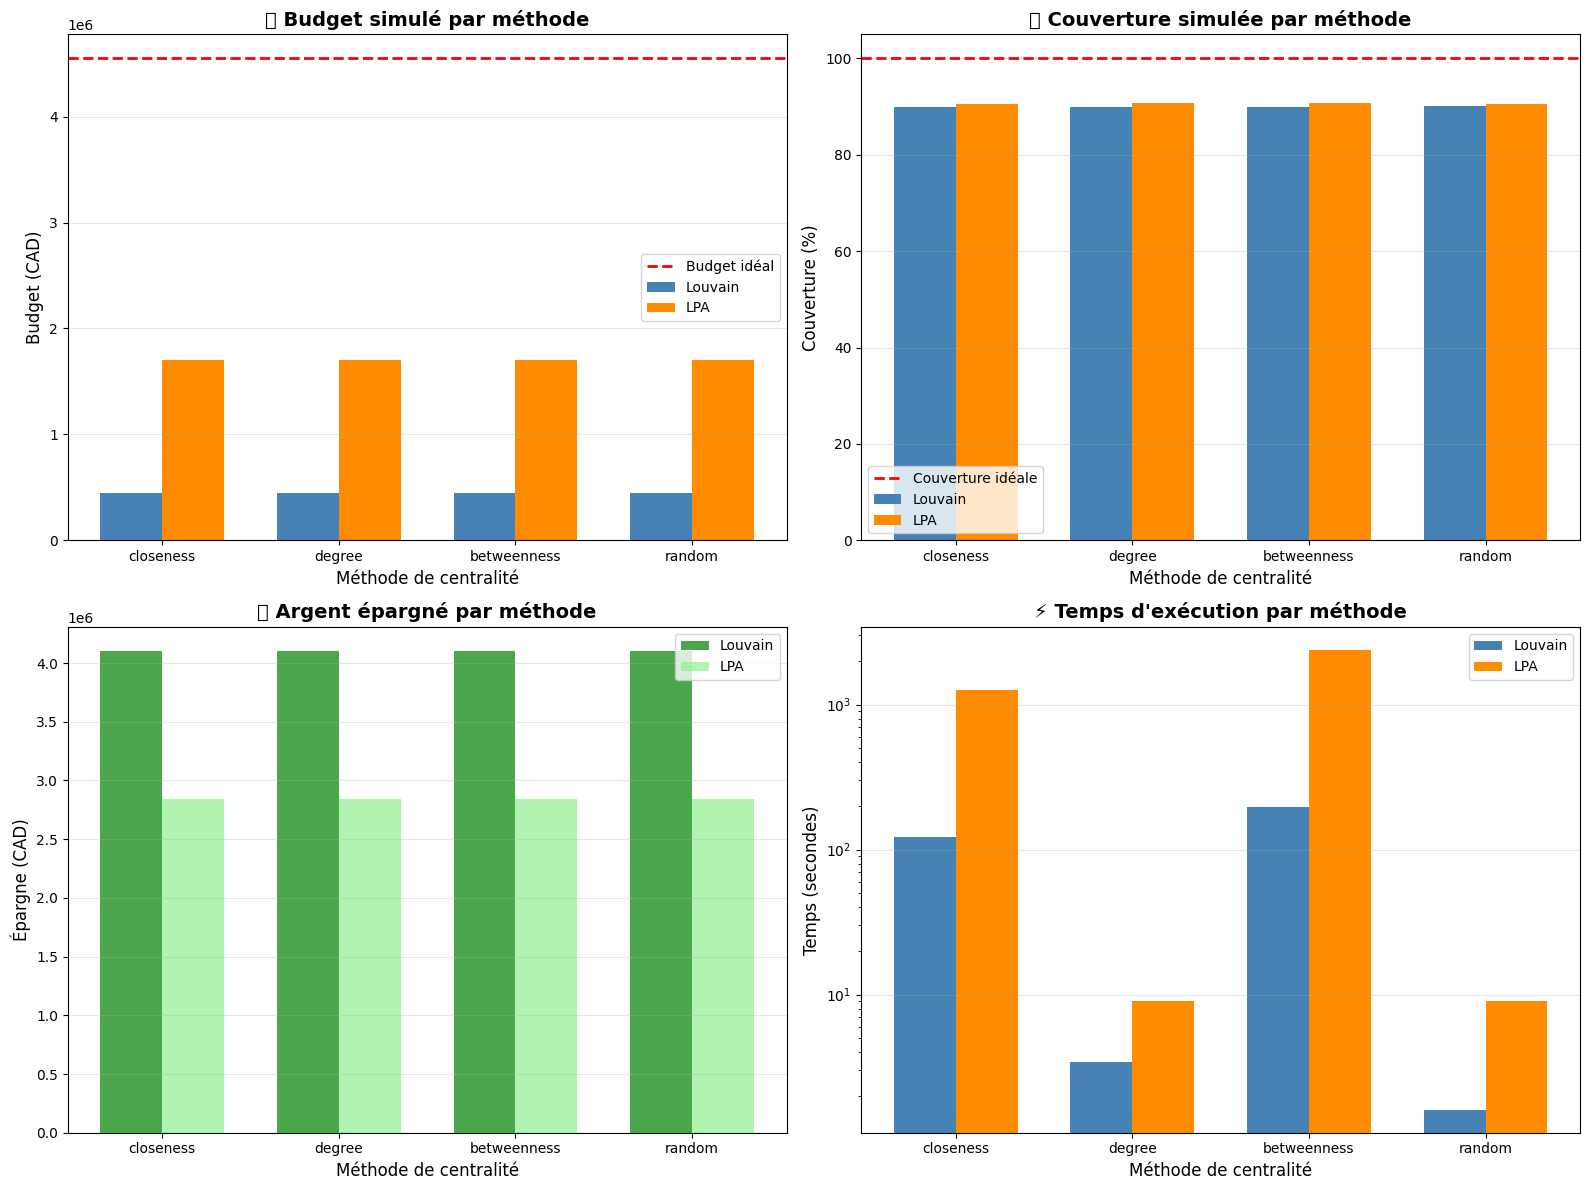

✅ Graphiques sauvegardés dans 'comparaison_complete.png'


In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Préparer les données pour l'affichage groupé
louvain_data = df_resultats[df_resultats['algorithme'] == 'Louvain']
lpa_data = df_resultats[df_resultats['algorithme'] == 'LPA']
centralites = ['closeness', 'degree', 'betweenness', 'random']
x = np.arange(len(centralites))
width = 0.35

# 1. Budget
ax1 = axes[0, 0]
ax1.bar(x - width/2, louvain_data['budget'], width, label='Louvain', color='steelblue')
ax1.bar(x + width/2, lpa_data['budget'], width, label='LPA', color='darkorange')
ax1.axhline(y=ideal_budget, color='red', linestyle='--', linewidth=2, label='Budget idéal')
ax1.set_title(' Budget simulé par méthode', fontsize=14, fontweight='bold')
ax1.set_ylabel('Budget (CAD)', fontsize=12)
ax1.set_xlabel('Méthode de centralité', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(centralites)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Couverture
ax2 = axes[0, 1]
ax2.bar(x - width/2, louvain_data['couverture']*100, width, label='Louvain', color='steelblue')
ax2.bar(x + width/2, lpa_data['couverture']*100, width, label='LPA', color='darkorange')
ax2.axhline(y=100, color='red', linestyle='--', linewidth=2, label='Couverture idéale')
ax2.set_title('Couverture simulée par méthode', fontsize=14, fontweight='bold')
ax2.set_ylabel('Couverture (%)', fontsize=12)
ax2.set_xlabel('Méthode de centralité', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(centralites)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Argent épargné
ax3 = axes[1, 0]
ax3.bar(x - width/2, louvain_data['argent_epargne'], width, label='Louvain', color='green', alpha=0.7)
ax3.bar(x + width/2, lpa_data['argent_epargne'], width, label='LPA', color='lightgreen', alpha=0.7)
ax3.set_title(' Argent épargné par méthode', fontsize=14, fontweight='bold')
ax3.set_ylabel('Épargne (CAD)', fontsize=12)
ax3.set_xlabel('Méthode de centralité', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(centralites)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Temps d'exécution (échelle log pour mieux voir)
ax4 = axes[1, 1]
ax4.bar(x - width/2, louvain_data['temps_execution'], width, label='Louvain', color='steelblue')
ax4.bar(x + width/2, lpa_data['temps_execution'], width, label='LPA', color='darkorange')
ax4.set_title(' Temps d\'exécution par méthode', fontsize=14, fontweight='bold')
ax4.set_ylabel('Temps (secondes)', fontsize=12)
ax4.set_xlabel('Méthode de centralité', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(centralites)
ax4.set_yscale('log')  # Échelle logarithmique
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparaison_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graphiques sauvegardés dans 'comparaison_complete.png'")




/tmp/ipython-input-266844025.py:59: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-266844025.py:60: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig('budget_par_methode_ameliore.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


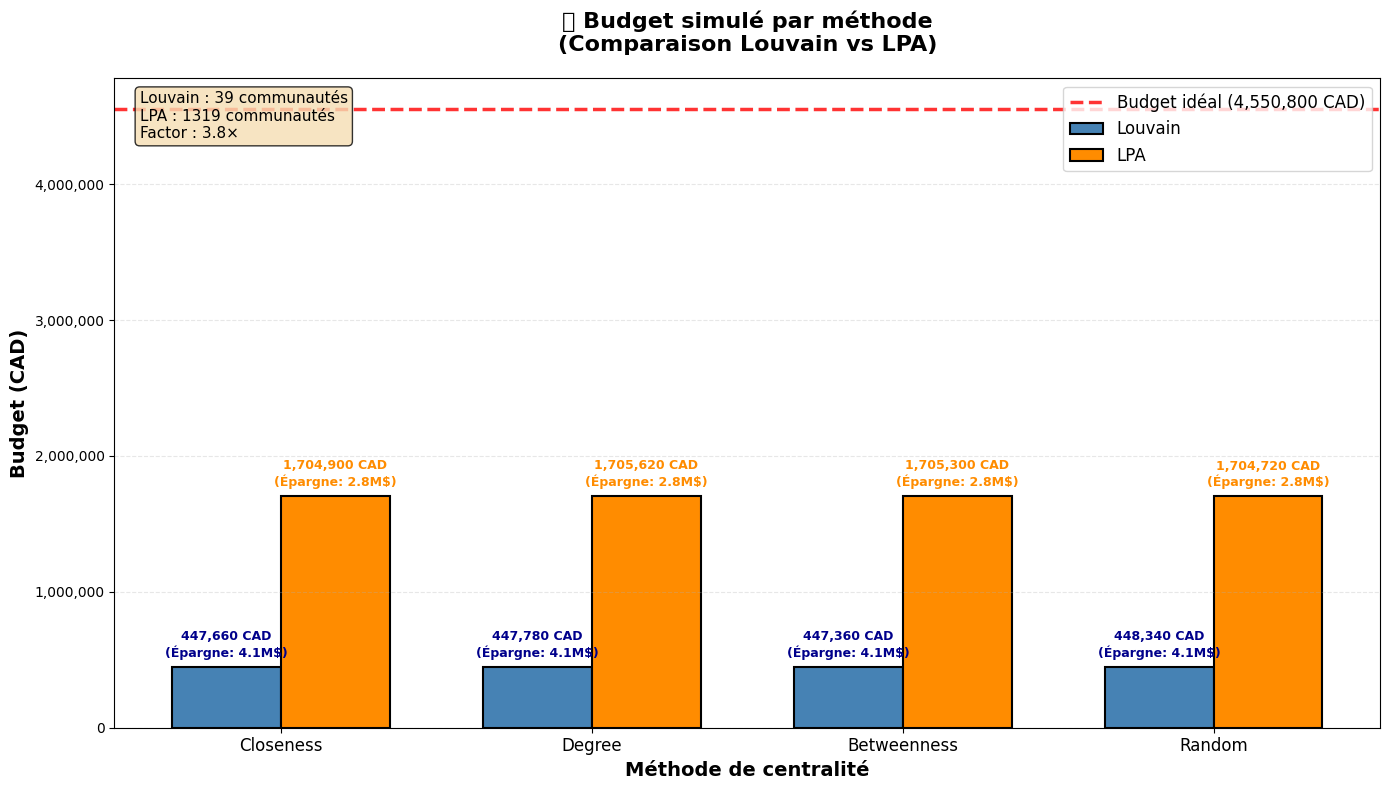

✅ Graphique amélioré sauvegardé !


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Préparer les données
louvain_data = df_resultats[df_resultats['algorithme'] == 'Louvain']
lpa_data = df_resultats[df_resultats['algorithme'] == 'LPA']
centralites = ['Closeness', 'Degree', 'Betweenness', 'Random']
x = np.arange(len(centralites))
width = 0.35

# Créer la figure
fig, ax = plt.subplots(figsize=(14, 8))

# Barres
bars1 = ax.bar(x - width/2, louvain_data['budget'], width,
               label='Louvain', color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, lpa_data['budget'], width,
               label='LPA', color='darkorange', edgecolor='black', linewidth=1.5)

# Ligne budget idéal
ax.axhline(y=ideal_budget, color='red', linestyle='--', linewidth=2.5,
           label=f'Budget idéal ({ideal_budget:,.0f} CAD)', alpha=0.8)

# Annotations sur les barres (valeurs + économie)
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Louvain
    height1 = bar1.get_height()
    epargne1 = ideal_budget - height1
    ax.text(bar1.get_x() + bar1.get_width()/2, height1 + 50000,
            f'{height1:,.0f} CAD\n(Épargne: {epargne1/1e6:.1f}M$)',
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkblue')

    # LPA
    height2 = bar2.get_height()
    epargne2 = ideal_budget - height2
    ax.text(bar2.get_x() + bar2.get_width()/2, height2 + 50000,
            f'{height2:,.0f} CAD\n(Épargne: {epargne2/1e6:.1f}M$)',
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkorange')

# Labels et titre
ax.set_xlabel('Méthode de centralité', fontsize=14, fontweight='bold')
ax.set_ylabel('Budget (CAD)', fontsize=14, fontweight='bold')
ax.set_title(' Budget simulé par méthode\n(Comparaison Louvain vs LPA)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(centralites, fontsize=12)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Format de l'axe Y avec séparateurs de milliers
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Ajouter un texte explicatif
textstr = f'Louvain : 39 communautés\nLPA : 1319 communautés\nFactor : {lpa_data["budget"].mean()/louvain_data["budget"].mean():.1f}×'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('budget_par_methode_ameliore.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graphique amélioré sauvegardé !")

/tmp/ipython-input-4266186318.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4266186318.py:56: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('couverture_amelioree.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


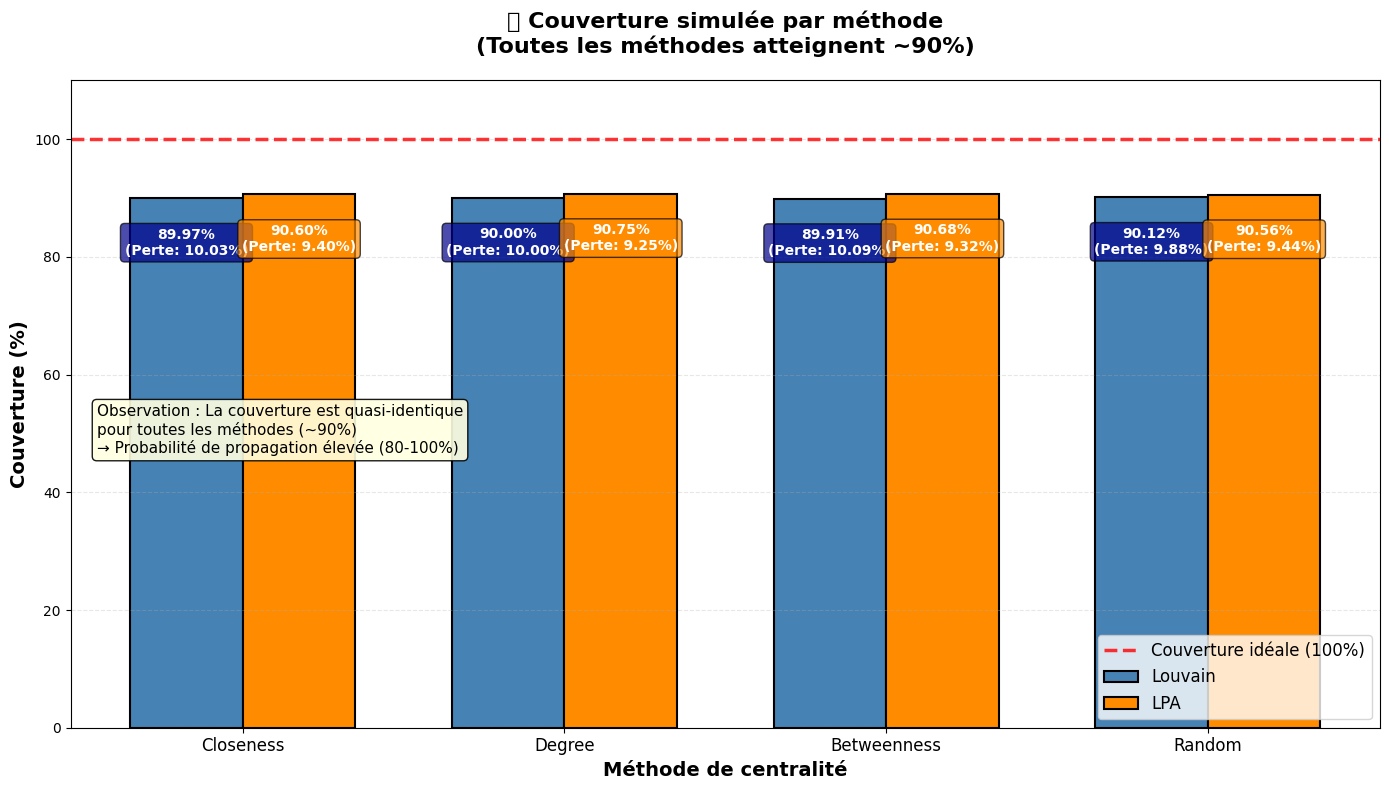

In [45]:
import matplotlib.pyplot as plt
import numpy as np

louvain_data = df_resultats[df_resultats['algorithme'] == 'Louvain']
lpa_data = df_resultats[df_resultats['algorithme'] == 'LPA']
centralites = ['Closeness', 'Degree', 'Betweenness', 'Random']
x = np.arange(len(centralites))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - width/2, louvain_data['couverture']*100, width,
               label='Louvain', color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, lpa_data['couverture']*100, width,
               label='LPA', color='darkorange', edgecolor='black', linewidth=1.5)

# Ligne couverture idéale
ax.axhline(y=100, color='red', linestyle='--', linewidth=2.5,
           label='Couverture idéale (100%)', alpha=0.8)

# Annotations avec valeurs exactes + perte
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Louvain
    height1 = bar1.get_height()
    perte1 = 100 - height1
    ax.text(bar1.get_x() + bar1.get_width()/2, height1 - 5,
            f'{height1:.2f}%\n(Perte: {perte1:.2f}%)',
            ha='center', va='top', fontsize=10, fontweight='bold',
            color='white', bbox=dict(boxstyle='round', facecolor='darkblue', alpha=0.7))

    # LPA
    height2 = bar2.get_height()
    perte2 = 100 - height2
    ax.text(bar2.get_x() + bar2.get_width()/2, height2 - 5,
            f'{height2:.2f}%\n(Perte: {perte2:.2f}%)',
            ha='center', va='top', fontsize=10, fontweight='bold',
            color='white', bbox=dict(boxstyle='round', facecolor='darkorange', alpha=0.7))

ax.set_xlabel('Méthode de centralité', fontsize=14, fontweight='bold')
ax.set_ylabel('Couverture (%)', fontsize=14, fontweight='bold')
ax.set_title('📊 Couverture simulée par méthode\n(Toutes les méthodes atteignent ~90%)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(centralites, fontsize=12)
ax.set_ylim([0, 110])
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Texte explicatif
textstr = 'Observation : La couverture est quasi-identique\npour toutes les méthodes (~90%)\n→ Probabilité de propagation élevée (80-100%)'
props = dict(boxstyle='round', facecolor='lightyellow', alpha=0.9)
ax.text(0.02, 0.50, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('couverture_amelioree.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-3261951004.py:41: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3261951004.py:41: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3261951004.py:42: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig('epargne_amelioree.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-3261951004.py:42: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.savefig('epargne_amelioree.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC

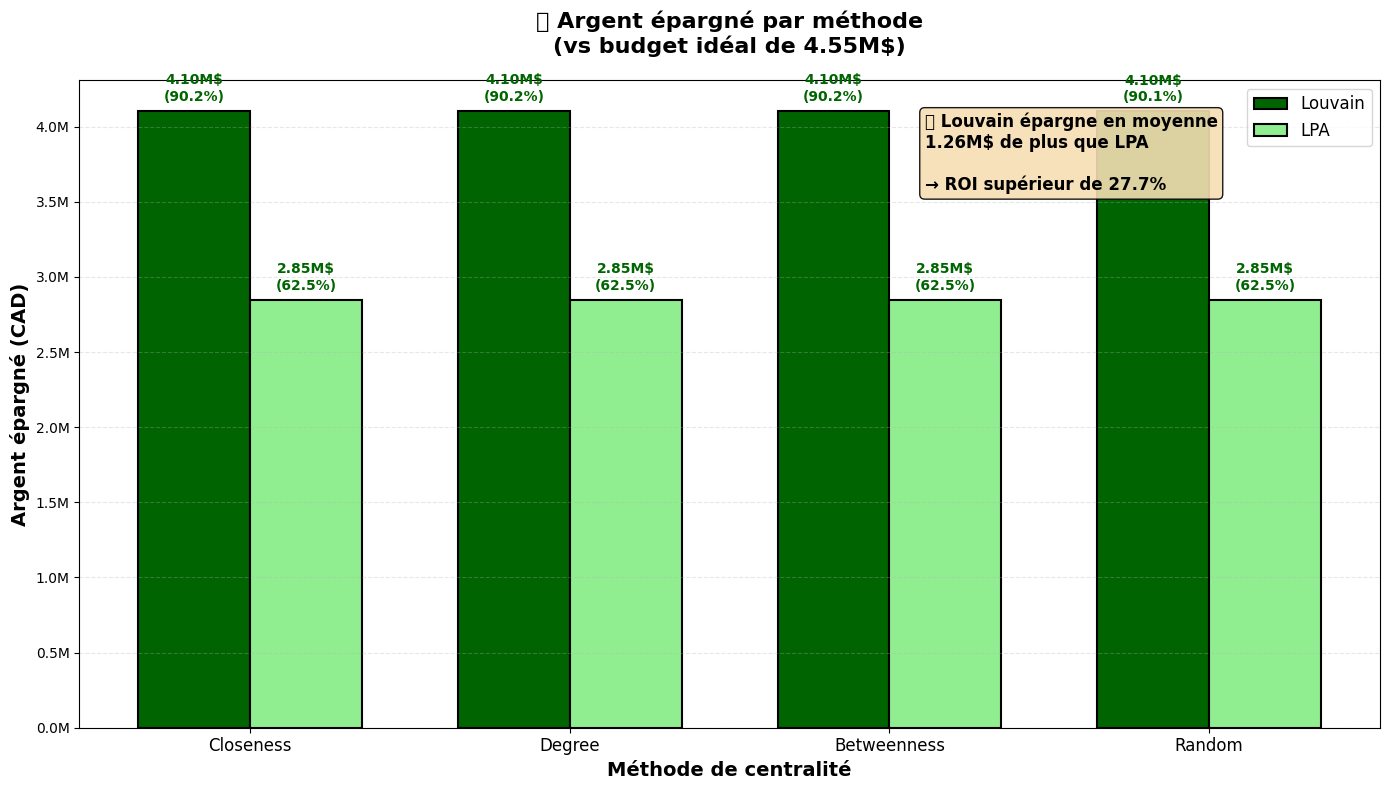

In [43]:
fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - width/2, louvain_data['argent_epargne'], width,
               label='Louvain', color='darkgreen', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, lpa_data['argent_epargne'], width,
               label='LPA', color='lightgreen', edgecolor='black', linewidth=1.5)

# Annotations avec valeurs + pourcentages
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Louvain
    height1 = bar1.get_height()
    pct1 = (height1 / ideal_budget) * 100
    ax.text(bar1.get_x() + bar1.get_width()/2, height1 + 50000,
            f'{height1/1e6:.2f}M$\n({pct1:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkgreen')

    # LPA
    height2 = bar2.get_height()
    pct2 = (height2 / ideal_budget) * 100
    ax.text(bar2.get_x() + bar2.get_width()/2, height2 + 50000,
            f'{height2/1e6:.2f}M$\n({pct2:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkgreen')

ax.set_xlabel('Méthode de centralité', fontsize=14, fontweight='bold')
ax.set_ylabel('Argent épargné (CAD)', fontsize=14, fontweight='bold')
ax.set_title('💵 Argent épargné par méthode\n(vs budget idéal de 4.55M$)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(centralites, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Différence Louvain vs LPA
diff_moyenne = louvain_data['argent_epargne'].mean() - lpa_data['argent_epargne'].mean()
textstr = f' Louvain épargne en moyenne\n{diff_moyenne/1e6:.2f}M$ de plus que LPA\n\n→ ROI supérieur de 27.7%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props, fontweight='bold')

plt.tight_layout()
plt.savefig('epargne_amelioree.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-2495497557.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2495497557.py:58: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2495497557.py:58: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2495497557.py:58: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-2495497557.py:59: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('temps_execution_ameliore.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2495497557.py:59: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('temps_execution_ameliore.png', dpi=300, bbox_inches='tight')
/tmp/ipython-input-2495497557.py:59: UserWarning: Glyph 1

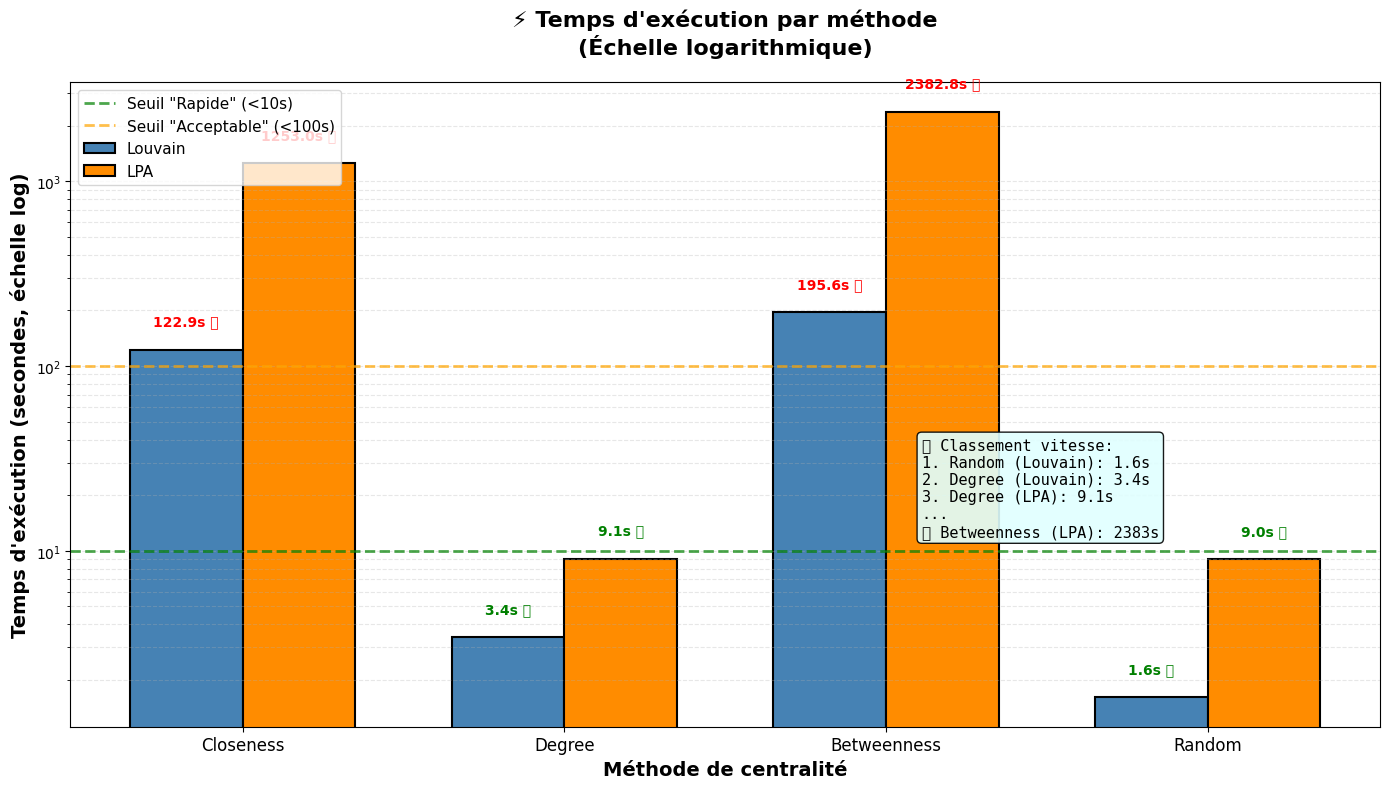

In [44]:
fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.bar(x - width/2, louvain_data['temps_execution'], width,
               label='Louvain', color='steelblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, lpa_data['temps_execution'], width,
               label='LPA', color='darkorange', edgecolor='black', linewidth=1.5)

# Lignes de seuil
ax.axhline(y=10, color='green', linestyle='--', linewidth=2,
           label='Seuil "Rapide" (<10s)', alpha=0.7)
ax.axhline(y=100, color='orange', linestyle='--', linewidth=2,
           label='Seuil "Acceptable" (<100s)', alpha=0.7)

# Annotations
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Louvain
    height1 = bar1.get_height()
    if height1 < 10:
        couleur1, emoji1 = 'green', '✅'
    elif height1 < 100:
        couleur1, emoji1 = 'orange', '⚠️'
    else:
        couleur1, emoji1 = 'red', '❌'

    ax.text(bar1.get_x() + bar1.get_width()/2, height1 * 1.3,
            f'{height1:.1f}s {emoji1}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=couleur1)

    # LPA
    height2 = bar2.get_height()
    if height2 < 10:
        couleur2, emoji2 = 'green', '✅'
    elif height2 < 100:
        couleur2, emoji2 = 'orange', '⚠️'
    else:
        couleur2, emoji2 = 'red', '❌'

    ax.text(bar2.get_x() + bar2.get_width()/2, height2 * 1.3,
            f'{height2:.1f}s {emoji2}',
            ha='center', va='bottom', fontsize=10, fontweight='bold', color=couleur2)

ax.set_xlabel('Méthode de centralité', fontsize=14, fontweight='bold')
ax.set_ylabel('Temps d\'exécution (secondes, échelle log)', fontsize=14, fontweight='bold')
ax.set_title('⚡ Temps d\'exécution par méthode\n(Échelle logarithmique)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(centralites, fontsize=12)
ax.set_yscale('log')
ax.legend(fontsize=11, loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--', which='both')

# Classement
textstr = ' Classement vitesse:\n1. Random (Louvain): 1.6s\n2. Degree (Louvain): 3.4s\n3. Degree (LPA): 9.1s\n...\n❌ Betweenness (LPA): 2383s'
props = dict(boxstyle='round', facecolor='lightcyan', alpha=0.9)
ax.text(0.65, 0.45, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('temps_execution_ameliore.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-2083124601.py:37: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2083124601.py:38: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig('budget_epargne_empile.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


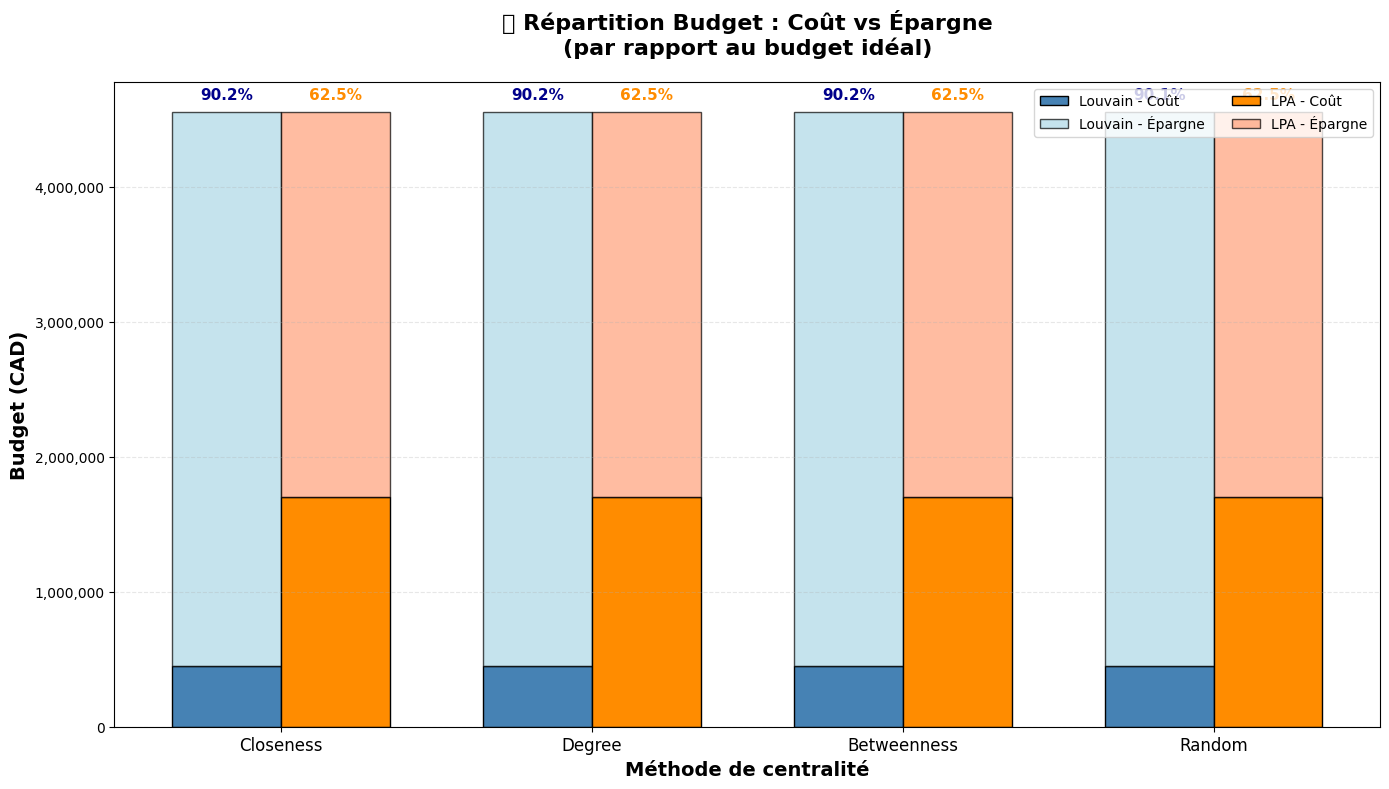

✅ Graphique épargne sauvegardé !


In [47]:
fig, ax = plt.subplots(figsize=(14, 8))

# Calculer le % d'épargne
louvain_epargne_pct = ((ideal_budget - louvain_data['budget']) / ideal_budget * 100).values
lpa_epargne_pct = ((ideal_budget - lpa_data['budget']) / ideal_budget * 100).values

# Barres empilées pour montrer coût + épargne
bars1_cout = ax.bar(x - width/2, louvain_data['budget'], width,
                    label='Louvain - Coût', color='steelblue', edgecolor='black')
bars1_epargne = ax.bar(x - width/2, ideal_budget - louvain_data['budget'], width,
                       bottom=louvain_data['budget'], label='Louvain - Épargne',
                       color='lightblue', edgecolor='black', alpha=0.7)

bars2_cout = ax.bar(x + width/2, lpa_data['budget'], width,
                    label='LPA - Coût', color='darkorange', edgecolor='black')
bars2_epargne = ax.bar(x + width/2, ideal_budget - lpa_data['budget'], width,
                       bottom=lpa_data['budget'], label='LPA - Épargne',
                       color='lightsalmon', edgecolor='black', alpha=0.7)

# Annotations % d'épargne
for i, (e1, e2) in enumerate(zip(louvain_epargne_pct, lpa_epargne_pct)):
    ax.text(x[i] - width/2, ideal_budget + 100000, f'{e1:.1f}%',
            ha='center', fontsize=11, fontweight='bold', color='darkblue')
    ax.text(x[i] + width/2, ideal_budget + 100000, f'{e2:.1f}%',
            ha='center', fontsize=11, fontweight='bold', color='darkorange')

ax.set_xlabel('Méthode de centralité', fontsize=14, fontweight='bold')
ax.set_ylabel('Budget (CAD)', fontsize=14, fontweight='bold')
ax.set_title(' Répartition Budget : Coût vs Épargne\n(par rapport au budget idéal)',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(centralites, fontsize=12)
ax.legend(fontsize=10, loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.savefig('budget_epargne_empile.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Graphique épargne sauvegardé !")